<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/main/new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 导入相关模块及数据

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.8 MB/s eta 0:00:00


In [2]:
# 导入模块
import time
import pandas as pd
import numpy as np
import random
import mpl_toolkits.axisartist as ast
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import copy
import shap
import scipy
from collections import UserList
from tabulate import tabulate
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:

# Load the dataset
file_path_car = '/content/car_dict_e8_emb.csv'
car_data = pd.read_csv(file_path_car)

file_path_user = '/content/dsc_up_e8.csv'
user_data = pd.read_csv(file_path_user)

# Display the first few rows of the dataframe
car_data.head()
user_data.head()

Columns (300,302,303,307,309,312,313,314,315,316,317) have mixed types. Specify dtype option on import or set low_memory=False.


,fkoubeiid,comments,purposes,province,city,budget,drivenkiloms,driving _months,km/d,fseriesname,fseriesid,fspecid,no_in_car_dict,type
0,5172505,【最满意的一点】\r\n我的用车需求匹配下来最合适的就是MPV，本来MPV市场可选的车型就不...,"上下班,购物,接送小孩,自驾游,商务差旅",四川,成都,29,1300,2.0,21.68,传祺M8,4174,58244,37,传祺M8 2024款 双擎系列 2.0TM 基本型
1,5168778,【最满意的一点】\r\n油耗很低，虽然买了一辆这么大的车，但载着一大家子出行，一般情况下油耗...,"上下班,自驾游,跑长途",上海,上海,32,6632,7.9,27.81,传祺M8,4174,60142,38,传祺M8 2023款 宗师系列 双擎 旗舰
2,5168549,【最满意的一点】\r\n现在不加价，在同价位的MPV中，我觉得赛那还是挺适合的，毕竟它的空间...,"上下班,自驾游,跑长途",北京,北京,36,3526,3.9,29.77,赛那SIENNA,6272,61955,121,赛那SIENNA 2023款 2.5L混动 尊贵版
3,5168444,【最满意的一点】\r\n空间是这个车子最大的优势，同时内部的配置也非常的齐全，再加上价格也比...,NaN,福建,厦门,10,0,0.9,0.00,五菱佳辰,6650,55788,2,五菱佳辰 2022款 1.5T CVT尊享旗舰型
4,5168430,【最满意的一点】\r\n公司业务需求里面需要外地出差考虑换一台商务车，公司换车首选就是别克陆...,"上下班,跑长途,商务差旅",河南,商丘,30,2400,0.9,91.26,别克GL8,166,58900,101,别克GL8 2023款 ES陆尊 653T 舒适型


# `预处理data`

In [4]:
# Remove columns with only one unique value
columns_to_drop = car_data.columns[car_data.nunique() <= 1]
car_data_reduced = car_data.drop(columns=columns_to_drop)

In [5]:
car_data_reduced.head(10)

,fspecid,price,quick_charge_time(80%),slow_charge_time,power_car,最大净功率,torque_car,gears,max_speed,time_for_100km_h,...,第二排座椅电动调节,第二排座椅功能,后排液晶屏幕尺寸,第三排座椅功能,第三排座椅调节,可见即可说,语音免唤醒词,语音分区域唤醒识别,手机app远程功能,title
0,56818,8.18,0.0,0.0,108,104,250,6,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰
1,56817,9.18,0.0,0.0,108,104,250,0,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰
2,55788,9.98,0.0,0.0,108,104,250,0,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰
3,41053,11.98,0.0,0.0,124,117,265,7,190,11.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6
4,47564,10.98,0.0,0.0,124,117,265,6,195,10.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6
5,60951,15.98,0.0,0.0,130,125,270,7,190,9.40,...,-,-,NaN,NaN,NaN,-,●,-,●车门控制\r\n●车辆启动\r\n●空调控制\r\n●座椅加热\r\n●车况查询/诊断\r...,传祺M6
6,60948,12.98,0.0,0.0,130,125,270,7,190,9.40,...,-,-,NaN,NaN,NaN,-,-,-,-,传祺M6
7,60949,13.98,0.0,0.0,130,125,270,7,190,9.40,...,-,-,NaN,NaN,NaN,-,-,-,-,传祺M6
8,60950,14.98,0.0,0.0,130,125,270,7,190,9.40,...,-,-,NaN,NaN,NaN,-,-,-,-,传祺M6
9,47571,14.98,0.0,0.0,124,117,265,7,190,11.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6


In [6]:
# Define the new function to handle multiple ● symbols
def replace_with_detailed_feature_description(cell, feature_name):
    if pd.isna(cell):
        return cell  # Keep NaN as is
    elif isinstance(cell, str):
        # Replace specific symbols with words
        cell = cell.replace('●', '有').replace('○', '选配').replace('-', '不具有').replace('NULL', '未知')
        # Find all occurrences of "有" which indicates a feature is present
        features = cell.split()
        feature_descriptions = []
        for feature in features:
            if feature.startswith('有'):
                feature_description = feature[1:]  # Remove the '有' prefix
                feature_descriptions.append(feature_description)
        if feature_descriptions:
            return f"具备{feature_name}功能，" + "、".join(feature_descriptions)
        else:
            # If there are no '有', but the cell is not empty or NaN, it means
            # it's either '选配', '不具有' or '未知'
            return cell + feature_name + "功能"
    else:
        return cell  # Keep the original value if it doesn't match the above


In [7]:
# Apply the new function to each non-numeric cell
for column in car_data_reduced.columns:
    if car_data_reduced[column].dtype == 'object':  # Apply only to non-numeric columns
        feature_name = column.strip()  # Clean up the column name if necessary
        car_data_reduced[column] = car_data_reduced[column].apply(lambda cell:
                               replace_with_detailed_feature_description(cell, feature_name))


In [8]:
car_data_reduced.head(10)

,fspecid,price,quick_charge_time(80%),slow_charge_time,power_car,最大净功率,torque_car,gears,max_speed,time_for_100km_h,...,第二排座椅电动调节,第二排座椅功能,后排液晶屏幕尺寸,第三排座椅功能,第三排座椅调节,可见即可说,语音免唤醒词,语音分区域唤醒识别,手机app远程功能,title
0,56818,8.18,0.0,0.0,108,104,250,6,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰title功能
1,56817,9.18,0.0,0.0,108,104,250,0,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰title功能
2,55788,9.98,0.0,0.0,108,104,250,0,170,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,五菱佳辰title功能
3,41053,11.98,0.0,0.0,124,117,265,7,190,11.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6title功能
4,47564,10.98,0.0,0.0,124,117,265,6,195,10.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6title功能
5,60951,15.98,0.0,0.0,130,125,270,7,190,9.40,...,不具有第二排座椅电动调节功能,不具有第二排座椅功能功能,NaN,NaN,NaN,不具有可见即可说功能,具备语音免唤醒词功能，,不具有语音分区域唤醒识别功能,具备手机app远程功能功能，车门控制、车辆启动、空调控制、座椅加热、车况查询/诊断、车辆定位/寻车,传祺M6title功能
6,60948,12.98,0.0,0.0,130,125,270,7,190,9.40,...,不具有第二排座椅电动调节功能,不具有第二排座椅功能功能,NaN,NaN,NaN,不具有可见即可说功能,不具有语音免唤醒词功能,不具有语音分区域唤醒识别功能,不具有手机app远程功能功能,传祺M6title功能
7,60949,13.98,0.0,0.0,130,125,270,7,190,9.40,...,不具有第二排座椅电动调节功能,不具有第二排座椅功能功能,NaN,NaN,NaN,不具有可见即可说功能,不具有语音免唤醒词功能,不具有语音分区域唤醒识别功能,不具有手机app远程功能功能,传祺M6title功能
8,60950,14.98,0.0,0.0,130,125,270,7,190,9.40,...,不具有第二排座椅电动调节功能,不具有第二排座椅功能功能,NaN,NaN,NaN,不具有可见即可说功能,不具有语音免唤醒词功能,不具有语音分区域唤醒识别功能,不具有手机app远程功能功能,传祺M6title功能
9,47571,14.98,0.0,0.0,124,117,265,7,190,11.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,传祺M6title功能


In [9]:
# Define the path for the cleaned CSV file
cleaned_file_path = '/content/cleaned_car_data.csv'

# Save the cleaned dataframe to a CSV file
car_data_reduced.to_csv(cleaned_file_path, index=False)  # Set index to False to avoid saving the index


In [10]:
dsc_up = user_data.values
car_dict = car_data_reduced.values

print(dsc_up.shape)
print(car_dict.shape)

(5520, 14)
(142, 239)


In [11]:
# column of last feature from 0 and +1
col_last_feature_car = 238
# 80
col_last_num_feature_car = 38

col_last_feature_user = 9

col_last_num_feature_user = 5

# 提取特征列表
dsc_up_features = user_data.columns.tolist()
car_dict_features = car_data_reduced.columns.tolist()

dsc_up_features = user_data.columns[1:col_last_feature_user].tolist() # 提取第1至28个特征
car_dict_features = car_data_reduced.columns[1:col_last_feature_car].tolist() # 提取第1至155个特征
car_dict_num_features = car_data_reduced.columns[1:col_last_num_feature_car].tolist() # 提取第151至155个特征
dsc_up_num_features = user_data.columns[1:col_last_num_feature_user].tolist()
#

print(dsc_up_features)
print(car_dict_features)
print(dsc_up_features[-1])
print(car_dict_features[-1])
print(car_dict_num_features[-1])
print(dsc_up_num_features[-1])

['comments', 'purposes', 'province', 'city', 'budget', 'drivenkiloms', 'driving _months', 'km/d']
['price', 'quick_charge_time(80%)', 'slow_charge_time', 'power_car', '最大净功率', 'torque_car', 'gears', 'max_speed', 'time_for_100km_h', 'pure_electric_endurance_mileage', 'endurance_mileage', '电动机总功率', '电动机总扭矩', '前电动机最大功率', '前电动机最大扭矩', '后电动机最大功率', '后电动机最大扭矩', '驱动电机数', 'length', 'width', 'height', 'wheel_base', 'front_gauge', 'track_rear', 'curb_weight', 'seats', '扬声器数量', '中控屏幕尺寸', '后备厢容积min', '后备厢容积max', '超声波雷达数量', '毫米波雷达数量', '快充功率', '怠速车内噪声', '速度60车内噪声', '速度80车内噪声', '速度120车内噪声', '厂商', '级别', '能源类型', '发动机', '变速箱', '整车质保', '电机类型', '驱动电机数.1', '电机布局', '电池类型', '电池组质保', '变速箱类型', '驱动方式', '后悬架类型', '后制动器类型', '驻车制动类型', '前轮胎规格', '后轮胎规格', '备胎规格', '主_副驾驶座安全气囊', '前_后排侧气囊', '前_后排头部气囊', '膝部气囊', '胎压监测功能', '安全带未系提醒', 'ISOFIX儿童座椅接口', 'ABS防抱死', '制动力分配', '刹车辅助', '牵引力控制', '车身稳定控制', '并线辅助', '车道偏离预警系统', '车道保持辅助系统', '道路交通标识识别', '主动刹车_主动安全系统', '疲劳驾驶提示', '前_后驻车雷达', '驾驶辅助影像', '倒车车侧预警系统', '巡航系统', '驾驶模式切换', '自动泊车入位', '发动

In [12]:
num_cars = len(car_dict)
print(f'The No. of cars in fundamental model dataset : {num_cars}')

The No. of cars in fundamental model dataset : 142


In [13]:
# balance dsc_up samples
dsc_up_bal = np.empty(shape=(1, dsc_up.shape[1]))

for i in range(num_cars):
  if len(dsc_up[user_data.no_in_car_dict == i]) > 300:
    ran_row_bal = np.random.choice(np.arange(len(dsc_up[user_data.no_in_car_dict == i])), size=300, replace=False)
    dsc_up_bali = dsc_up[user_data.no_in_car_dict == i][ran_row_bal]
  else:
    dsc_up_bali = dsc_up[user_data.no_in_car_dict == i]
  dsc_up_bal = np.concatenate((dsc_up_bal, dsc_up_bali), axis=0)
dsc_up = dsc_up_bal[1:]
print(dsc_up.shape)

(4945, 14)


In [14]:
# load the label
print(f'The shape of cars dict of the fundamental model dataset : {car_dict.shape}')
print(f'The shape of users list of the fundamental model dataset : {dsc_up.shape}')

ys_up = dsc_up[:, 12]
print(f'The label of which user choosed which car in fundamental dataset : {ys_up}')

The shape of cars dict of the fundamental model dataset : (142, 239)
The shape of users list of the fundamental model dataset : (4945, 14)
The label of which user choosed which car in fundamental dataset : [0 0 0 ... 141 141 141]


In [15]:
# transfer the label of fundamental dataset to onehot_code
ys = copy.copy(ys_up.reshape(len(ys_up), 1))
ys -= 1
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(ys)
ys = onehot_encoded
print(f'The shape of the label of fundamental dataset to onehot_code : {ys.shape}')


The shape of the label of fundamental dataset to onehot_code : (4945, 142)


In [16]:
car_unscaled = car_dict[:, 1:col_last_feature_car]
user_unscaled = dsc_up[:, 1:col_last_feature_user]


# generate the gaussian random no. to budget feature
mu_budget = 0.5
sigma_budget = 2

for i in range(len(user_unscaled)):
    user_unscaled[i, 4] += random.gauss(mu_budget, sigma_budget)

car = car_unscaled.copy()
user = user_unscaled.copy()

# car_num_unscaled = car_unscaled[:, 0:col_last_num_feature_car-1]
# user_num_unscaled = user_unscaled[:, (col_last_num_feature_user-1):(col_last_feature_user-1)]

# car_nnum_unscaled = car_unscaled[:, col_last_num_feature_car-1:col_last_feature_car-1]
# user_nnum_unscaled = user_unscaled[:, 0:col_last_num_feature_user-1]

# print(car_nnum_unscaled.shape)
# print(user_nnum_unscaled.shape)

In [17]:
# scaling the data
scalerCar = StandardScaler()
scalerCar.fit(car_unscaled[:, 0:col_last_num_feature_car-1])
car_nume = scalerCar.transform(car_unscaled[:, 0:col_last_num_feature_car-1])
car[:, 0:col_last_num_feature_car-1] = car_nume

scalerUser = StandardScaler()
scalerUser.fit(user_unscaled[:, (col_last_num_feature_user-1):(col_last_feature_user-1)])
user_nume = scalerUser.transform(user_unscaled[:, (col_last_num_feature_user-1):(col_last_feature_user-1)])
user[:, col_last_num_feature_user-1:col_last_feature_user-1] = user_nume

print(np.allclose(car_unscaled[:, 0:col_last_num_feature_car-1].astype(float), scalerCar.inverse_transform(car_nume)))
print(np.allclose(user_unscaled[:, (col_last_num_feature_user-1):(col_last_feature_user-1)].astype(float), scalerUser.inverse_transform(user_nume)))

True
True


# 特征分析

# 样本匹配

In [18]:
# func for generating num_items users of different cars
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict matrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (1, num_items))
    return user_vecs

def gen_car_vecs(car_vec, num_users):
    car_vecs = np.tile(car_vec, (num_users, 1))
    return car_vecs

In [19]:
# generate num_items users for different cars
user_vecs = gen_user_vecs(user, len(car_dict))
user_vecs = user_vecs.reshape(-1, user.shape[1])
car_vecs = gen_car_vecs(car, len(dsc_up))
ys = ys.reshape(-1, 1)
print(f'The shape of user matrix in fundamental dataset : {user_vecs.shape}')
print(f'The shape of car matrix in fundamental dataset : {car_vecs.shape}')
print(f'The shape of label matrix in fundamental dataset : {ys.shape}')


The shape of user matrix in fundamental dataset : (702190, 8)
The shape of car matrix in fundamental dataset : (702190, 237)
The shape of label matrix in fundamental dataset : (702190, 1)


In [20]:
print(ys[ys == 0].shape)

(697245,)


In [21]:
randnum = random.randint(0, 100)
print(randnum)
random.seed(randnum)

34


In [22]:
# case 3
# Random choose the users which label is 0 in fundamental dataset

user_vecs_one = user_vecs[(ys == 1)[:, 0]]
user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
num_users = user_vecs_one.shape[0]
num_zeros = user_vecs_zero.shape[0]
random.seed(randnum)

sample_row = np.random.choice(np.arange(num_zeros), size=np.ceil(num_users * 1.2).astype(int), replace=False)
user_vecs_zero = user_vecs_zero[sample_row]
user_vecs = np.concatenate((user_vecs_zero, user_vecs_one), axis=0)

# random.seed(44)
shuffle_row = np.random.choice(np.arange(0,len(user_vecs)), len(user_vecs), replace=False)
user_vecs = user_vecs[shuffle_row]
print(f'The shape of the users data in fundatmental dataset after balancing : {user_vecs.shape}')

The shape of the users data in fundatmental dataset after balancing : (10879, 8)


In [23]:
# case3
# Random choose the cars which label is 0 in fundamental dataset

car_vecs_one = car_vecs[(ys == 1)[:, 0]]
car_vecs_zero = car_vecs[(ys == 0)[:, 0]][sample_row]
car_vecs = np.concatenate((car_vecs_zero, car_vecs_one), axis=0)

car_vecs = car_vecs[shuffle_row]
print(f'The shape of the cars data in fundatmental dataset after balancing : {car_vecs.shape}')

The shape of the cars data in fundatmental dataset after balancing : (10879, 237)


In [24]:
# case 3
# Random choose the label which is 0 in fundamental dataset
ys_one = ys[(ys == 1)[:, 0]]
ys_zero = ys[(ys == 0)[:, 0]][sample_row]
ys = np.concatenate((ys_zero, ys_one), axis=0)

ys = ys[shuffle_row]
print(f'The shape of label data in fundatmental dataset after balancing : {ys.shape}')

The shape of label data in fundatmental dataset after balancing : (10879, 1)


In [25]:
user_vecs_nnum = user_vecs[:, 0:col_last_num_feature_user-1]
user_vecs_num = user_vecs[:, (col_last_num_feature_user-1):(col_last_feature_user-1)]

car_vecs_nnum = car_vecs[:, col_last_num_feature_car-1:col_last_feature_car-1]
car_vecs_num = car_vecs[:, 0:col_last_num_feature_car-1]

In [26]:
print(user_vecs_nnum.shape)
print(user_vecs_num.shape)
print(car_vecs_nnum.shape)
print(car_vecs_num.shape)

(10879, 4)
(10879, 4)
(10879, 200)
(10879, 37)


In [27]:
len(user_vecs_nnum[0, 0])

656

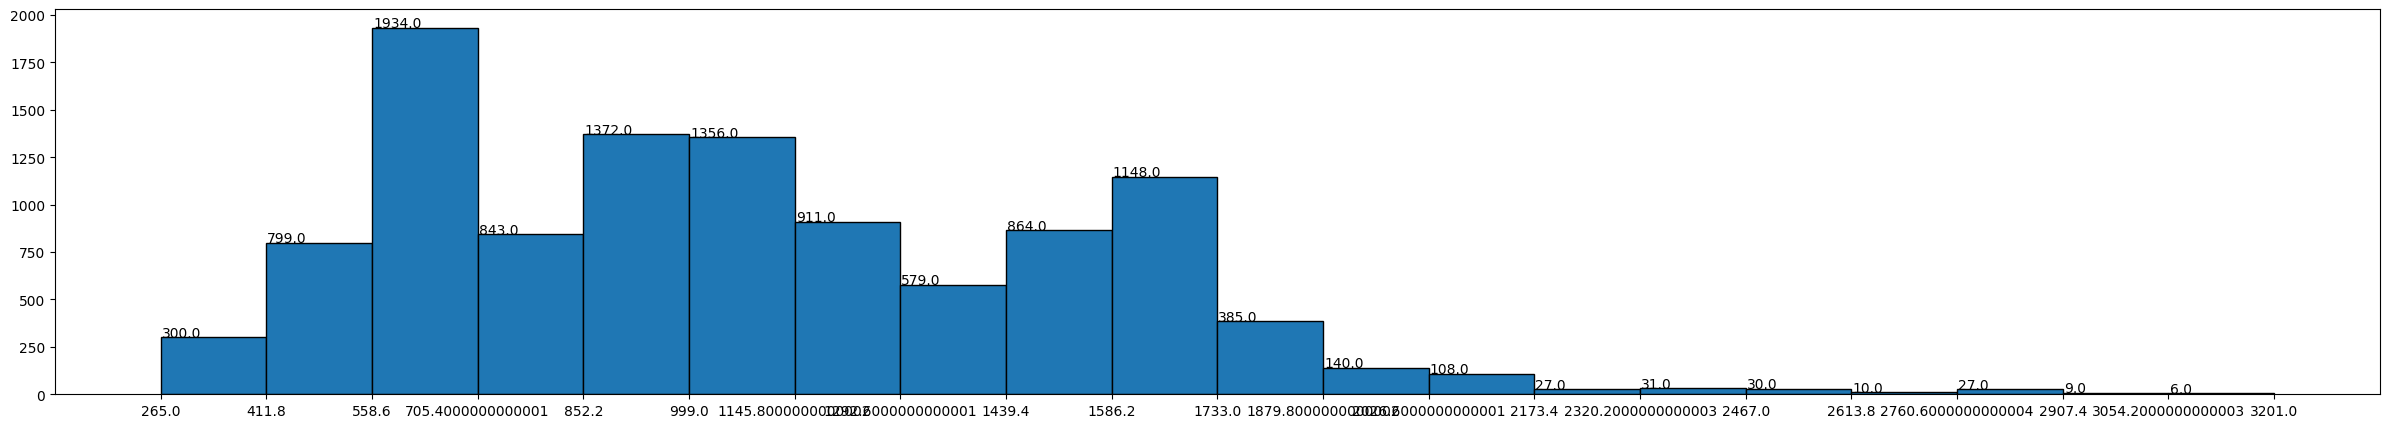

In [28]:
durations = []
for sent in user_vecs_nnum[:, 0]:
    durations.append(len(sent))
plt.figure(figsize=(30, 5))
nums, bins, patches = plt.hist(durations, bins=20, edgecolor='k')
plt.xticks(bins, bins)
for num, bin in zip(nums, bins):
    plt.annotate(num, xy=(bin, num), xytext=(bin + 1.5, num + 0.5))
plt.show()

In [29]:
user_vecs_nnum[0, 0]

'【最满意的一点】\r\n最让人满意的地方是它的空间、外观、性价比等方面。目前车辆没有出现异常问题。开的顺心安心放心。\r\n【最不满意的一点】\r\n腾势D9的NEDC纯电续航里程达到了190km还是有点端。 多媒体屏幕体验不佳，可能个人要求比较高，建议厂家在智能化再提高下。\r\n【空间】\r\n\r\n车子整体空间比较大配备中排同级最长电动滑轨，同时拥有超大第三排空间和灵活可变第四空间。这些特点使得车内空间非常充裕，可以在车内自由活动，不会感到拥挤或压抑。后备箱储物空间也不错的，可以放20寸拉杆箱4个左右。一家人出门旅游不错的。\r\n【动力】\r\n\r\n底盘较高，主驾驶视野开阔，座椅也很舒服，车内空间好得没话说，第二排座椅配置拉满，第三排空间也很富裕，成年人坐也很舒服。\r\n【操控】\r\n\r\n【油耗】\r\n\r\n插混模式，油耗表现不错，混动版百公里综合油耗为7L，动力十足。\r\n【舒适性】\r\n\r\n【外观】\r\n\r\n车辆的外观的话，采用了智慧与科技感并存的风格，整车线条流畅，气息高雅，符合豪华车的定位。车辆的前脸采用了家族式设计，搭配LED大灯和天使眼LED日间行车灯，独具特色。\r\n【内饰】\r\n\r\n座舱应用以驾乘者为中心的环抱式座舱布局，带来了沉浸式的数字座舱，整体风格简洁舒展，颇有优雅意境美感，尽展无限势能的生命美学。\r\n【性价比】\r\n\r\n同级别的MPV车型来说，性价比还算不错的。毕竟现在买东西都是一份价钱一份货的，腾势D9用料还是不错的。从外观到内饰，从动力到配置，腾势D9都展现出了高端豪华的品质。\r\n【为什么最终选择这款车】'